# Function Definitions and Imports

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from env import custom_oneDEnv
from network import Network
import numpy as np
from env import Anim
from matplotlib import animation, rc
from IPython.display import HTML, Image
from sklearn.linear_model import LinearRegression, BayesianRidge

In [7]:
def run(iterations, env, param_dict, s=10, number_of_neurons=100, initial_network=None, connection_mat=None):
    def write_in(scalar_normalized, s1, s2): # gets spike train according to normalized scalar observation between -1 and 1
        obs_pos = int(s1/(s1*scalar_normalized)) if scalar_normalized>0 else 0
        obs_neg = -int(s1/(s1*scalar_normalized)) if scalar_normalized<0 else 0
        obs_neg_v = np.array([[int(i%obs_neg==0)] for i in range(s2)]) if obs_neg!=0 else np.zeros((s2, 1))
        obs_pos_v = np.array([[int(i%obs_pos==0)] for i in range(s2)]) if obs_pos!=0 else np.zeros((s2, 1))
        return np.concatenate([obs_neg_v, obs_pos_v], axis=1)
        
    env.set_pos(np.random.rand()*2-1)
    if initial_network is None:
        net = Network(**param_dict)
        net.init_neurons(number_of_neurons=number_of_neurons)
        n_inputs = 3*2+4
        net.init_io_neurons(num_imputs=n_inputs,num_outputs=2) # Input: speed, acceleration, obs --> two neurons for each; Output: acceleration --W two neurons
        if connection_mat is None:
            net.M = connection_mat
            net.W = net.W * net.M
        for j in range(10): # initial weight convergence
            net.update_neurons(inputs=np.array([1]*n_inputs))
            net.update_weights()
    else:
        net = initial_network
        net.raster = []
    action= 0.0
    frames = []
    sum_activations = []
    entropies = []
    num_activations = []
    ys = []
    for i in range(iterations):
        inputs = env.step(action) # obs, vel, acc
        obs,vel,acc=inputs
        in_obs = write_in(obs, 15, s)
        in_vel = write_in(vel, 15, s)
        in_acc = write_in(acc, 15, s)
        output_image1 = write_in(2*net.postsyn_[net.output_neurons_indices[0]]-1, 15, s)
        output_image2 = write_in(2*net.postsyn_[net.output_neurons_indices[1]]-1, 15, s)
        
        
        inputs_ = np.concatenate((in_obs, in_vel, in_acc, output_image1, output_image2), axis=1)
        acs = 0
        o = np.zeros(2)
        for j in range(s):
            o += net.update_neurons(inputs=inputs_[j])
            net.update_weights()
            acs += np.sum(net.postsyn_)
        sum_activations.append(acs/s)
        o = (net.postsyn_[net.output_neurons_indices[0]], net.postsyn_[net.output_neurons_indices[1]])
        num_activations.append(np.sum(net.raster[-s:], axis=0))
        #action = (net.postsyn_[net.output_neurons_indices[0]]-net.postsyn_[net.output_neurons_indices[1]])
        action = (o[0]-o[1])/(o[0]+o[1]+1e-6)
        entropies.append(net.compute_entropy(s))
        if i%100==0:
            print("Iteration: {}\t Action: {}".format(i, action))
        y = [obs, vel, acc, action] # inputs to be reconstructed by the linear regression
        ys.append(y)
        frames.append(env.get_frame())
    return frames, sum_activations, net, entropies, np.array(num_activations)/s, np.array(ys)
def create_animation(frames, filename='plots/animation2.gif'):
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    def init_fr():
        return anim.init_frame(frames[0], ax)
    def animate(n):
        return anim.create_frame(frames[n])
    rc('animation', html='html5')
    ani = animation.FuncAnimation(fig, animate, frames=len(frames),
                                interval=100, blit=True, init_func=init_fr)
    ani.save(filename, writer='imagemagick', fps=60)

In [8]:
def optimize_for_entropy(params_dicts,iterations, env, param_dict, s=10, number_of_neurons=100, initial_network=None, connection_mat=None):
    best_entropies = [-1e10]
    best_params = None
    best_frames = None
    best_sum_activations = None
    best_net = None
    for params_dict in params_dicts:
        print("Optimizing for {}".format(params_dict))
        frames, sum_activations, net, entropies, num_activations, ys = run(iterations, env, param_dict, s, number_of_neurons, initial_network, connection_mat)
        if np.mean(entropies)>np.mean(best_entropies):
            print("New best entropy")
            best_entropies = entropies
            best_params = params_dict
            best_frames = frames
            best_sum_activations = sum_activations
            best_net = net
    return best_entropies, best_params, best_frames, best_sum_activations, best_net
    

In [9]:
def train_lin(x, y):
    LR = LinearRegression()
    LR.fit(x, y)
    return LR.score(x, y), LR
def train_bay(x, y):
    BR = BayesianRidge()
    BR.fit(x, y)
    y_mean, y_std = BR.predict(x, return_std=True)
    return BR.score(x, y), BR
def optimize_for_reconstruction(params_dicts,iterations, env, s=10, number_of_neurons=100, initial_network=None, connection_mat=None, reg_type='lin', include_inputs=False, quantities_optimized=None):
    best_accuracy = -1
    best_params = None
    best_frames = None
    best_num_activations = None
    best_net = None
    best_regressor = None
    best_ys = None
    for params_dict in params_dicts:
        print("Optimizing for {}".format(params_dict))
        frames, sum_activations, net, entropies, num_activations, ys_ = run(iterations, env, params_dict, s, number_of_neurons, initial_network, connection_mat)
        num_activations = np.array(num_activations)
        ys = ys_[:, quantities_optimized] if quantities_optimized is not None else ys
        if not include_inputs:
            num_activations_saved = np.copy(num_activations)
            i_not_input = [i for i in range(num_activations.shape[1]) if i not in net.input_neurons_indices]
            num_activations = num_activations[:, i_not_input]
        if reg_type=='lin':
            prediction_accuracy, _regressor= train_lin(num_activations, ys)
            prediction_accuracy, _regressor2= train_lin(num_activations_saved, ys_)
        elif reg_type=='bay':
            prediction_accuracy, _regressor = train_bay(num_activations, ys)
        else:
            assert callable(reg_type), "reg_type must be either 'lin' or 'bay' or a function"
            prediction_accuracy, _regressor = reg_type(num_activations, ys)
        if prediction_accuracy>best_accuracy:
            print("New best accuracy")
            best_accuracy = prediction_accuracy
            best_params = params_dict
            best_frames = frames
            best_num_activations = num_activations, num_activations_saved
            best_net = net
            best_regressor = _regressor, _regressor2
            best_ys = ys_
    return best_accuracy, best_params, best_frames, best_num_activations, best_net, best_regressor, best_ys

# Entropy optimization

In [10]:
params_dict = {'physical_dimensions': 2,
               'p_0': 0.5, 'lbd': 2, 
               'gamma': 2, 'avg_coef': 0.05, 'avg_sz_coef': 0.6, 
               'reset_v': -1, 
               'alpha1': 0.1, 'alpha2': 1.5,
               'dt': 0.005, 'update_eq': "LPL", "leak_current": 0.06,}

params = {"dt": [0.005, 0.006, 0.007, 0.008, 0.009, 0.01]}
params_dicts = []
for param in params.keys():
    for value in params[param]:
        params_dicts.append(params_dict.copy())
        params_dicts[-1][param] = value
        
env = custom_oneDEnv(interval_size=1, sf=2, ty="Deterministic")
anim = Anim(env.interval)
best_entropies, best_params, best_frames, best_sum_activations, best_net, ys = optimize_for_entropy(params_dicts, iterations=500, env=env, param_dict=params_dict, s=100, number_of_neurons=50, initial_network=None, connection_mat=np.load("data/M_100.npy"))

Optimizing for {'physical_dimensions': 2, 'p_0': 0.5, 'lbd': 2, 'gamma': 2, 'avg_coef': 0.05, 'avg_sz_coef': 0.6, 'reset_v': -1, 'alpha1': 0.1, 'alpha2': 1.5, 'dt': 0.005, 'update_eq': 'LPL', 'leak_current': 0.06}
initialize inputs and outputs neurons
Iteration: 0	 Action: 0.9999760900858836
Iteration: 100	 Action: 0.7843058356591112
Iteration: 200	 Action: 0.5246762706770964
Iteration: 300	 Action: 0.9999501092284803
Iteration: 400	 Action: 0.021889694239354936
New best entropy
Optimizing for {'physical_dimensions': 2, 'p_0': 0.5, 'lbd': 2, 'gamma': 2, 'avg_coef': 0.05, 'avg_sz_coef': 0.6, 'reset_v': -1, 'alpha1': 0.1, 'alpha2': 1.5, 'dt': 0.006, 'update_eq': 'LPL', 'leak_current': 0.06}
initialize inputs and outputs neurons
Iteration: 0	 Action: 0.0
Iteration: 100	 Action: -0.051193932310853216
Iteration: 200	 Action: -0.10285046473716958
Iteration: 300	 Action: 0.8554775198272697
Iteration: 400	 Action: 0.9999127490302552
New best entropy
Optimizing for {'physical_dimensions': 2, 'p

ValueError: not enough values to unpack (expected 6, got 5)

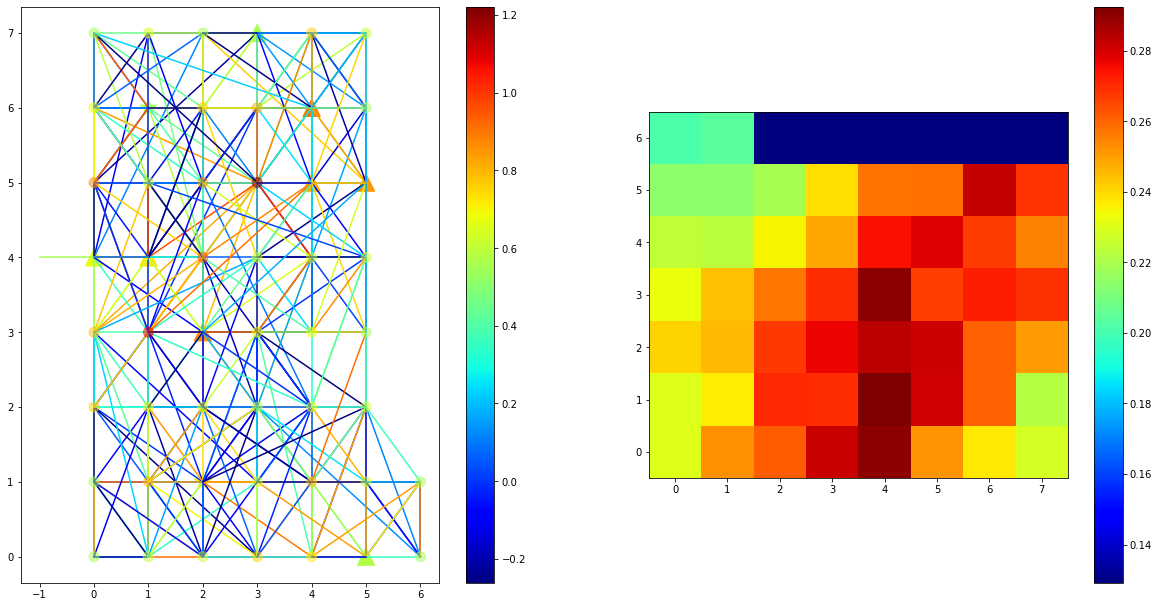

(218249,)


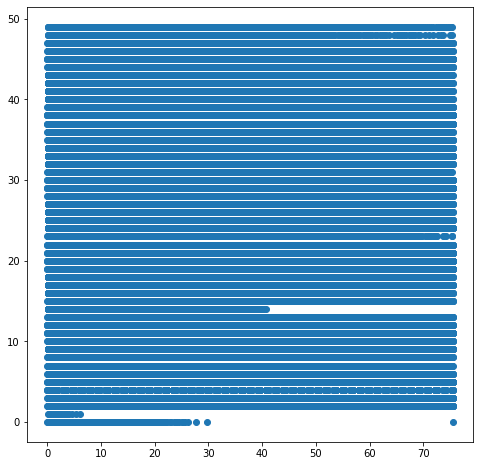

In [ ]:
best_net.visualize_network()
x,y=best_net.raster_plot()
plt.figure(figsize=(8,8))
print(np.array(x).shape)
plt.scatter(x,y)

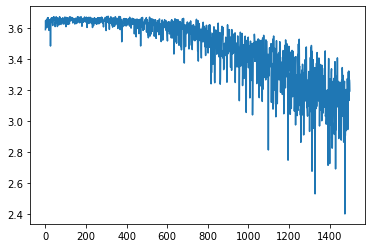

In [ ]:
plt.plot(best_entropies)

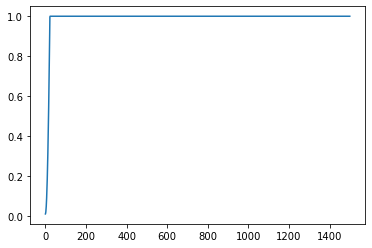

In [ ]:
positions = [frame[2] for frame in best_frames]
acceleration = [frame[-1] for frame in best_frames]

plt.plot(positions)

# Regression Accuracy Optimization

In [ ]:
def get_params_ditcs(params_dict, params):
    params_dicts = []
    for param in params.keys():
        for value in params[param]:
            params_dicts.append(params_dict.copy())
            params_dicts[-1][param] = value
    return params_dicts

In [ ]:
params_dictPA = {'physical_dimensions': 2,
               'p_0': 1, 'lbd': 2, 
               'gamma': 10, 'avg_coef': 0.3, 'avg_sz_coef': 0.6, 
               'reset_v': -2, 
               'alpha1': 0.5, 'alpha2': 0.52,
               'dt': 0.01, 'update_eq': "PA", "leak_current": 0.001}
params_dictLPL = {'physical_dimensions': 2,
               'p_0': 1, 'lbd': 2, 
               'gamma': 10, 'avg_coef': 0.4, 'avg_sz_coef': 0.6, 
               'reset_v': -1, 
               'alpha1': 0.5, 'alpha2': 0.5,
               'dt': 0.01, 'update_eq': "LPL", "leak_current": 0.001}
params_dictRD = {'physical_dimensions': 2,
               'p_0': 1.5, 'lbd': 2, 
               'gamma': 1, 'avg_coef': 0.1, 'avg_sz_coef': 0.6, 
               'reset_v': -1, 
               'alpha1': 0.5, 'alpha2': 1.5,
               'dt': 0.02, 'update_eq': "REQ_DIFF", "leak_current": 0.1}

In [ ]:
#paramsRD = {"p_0": [0.5, 0.7, 1, 1.5, 2]}
paramsLPL = {"lbd": [2]}
#paramsPA = {"alpha2": [0.5, 1, 1.5]}
params_dicts_LPL = get_params_ditcs(params_dictLPL, paramsLPL)
#params_dicts_PA = get_params_ditcs(params_dictPA, paramsPA)
#params_dicts_RD = get_params_ditcs(params_dictRD, paramsRD)
params_dicts = params_dicts_LPL
env = custom_oneDEnv(interval_size=1, sf=2, ty="Deterministic")
anim = Anim(env.interval)
# quantities_optimized = 0 is the observation setting to None optimizes over the prediction of all
best_accuracy, best_params, best_frames, (best_num_activations, a_saved), best_net, best_regressors, best_ys = optimize_for_reconstruction(params_dicts, iterations=500, env=env, s=40, number_of_neurons=50, initial_network=None, connection_mat=np.load("data/M_100.npy"), quantities_optimized=[0], include_inputs=False)


Optimizing for {'physical_dimensions': 2, 'p_0': 1, 'lbd': 2, 'gamma': 10, 'avg_coef': 0.4, 'avg_sz_coef': 0.6, 'reset_v': -1, 'alpha1': 0.5, 'alpha2': 0.5, 'dt': 0.01, 'update_eq': 'LPL', 'leak_current': 0.001}
initialize inputs and outputs neurons
Iteration: 0	 Action: 0.0
Iteration: 100	 Action: 0.0
Iteration: 200	 Action: 0.0
Iteration: 300	 Action: -1.8446866406500113e-59
Iteration: 400	 Action: -1.888019010671155e-65
New best accuracy


In [ ]:
print(best_params)
print(best_accuracy)

{'physical_dimensions': 2, 'p_0': 1, 'lbd': 2, 'gamma': 10, 'avg_coef': 0.4, 'avg_sz_coef': 0.6, 'reset_v': -1, 'alpha1': 0.5, 'alpha2': 0.5, 'dt': 0.01, 'update_eq': 'LPL', 'leak_current': 0.001}
0.5523192595037187


In [ ]:
def visualize_linear_predictions(x, x2, y, regressors, quantities_optimized=None):
    obs, vel, acc, action = y[:,0], y[:,1], y[:,2], y[:,3]
    r1, r2 = regressors
    pred = r1.predict(x)
    pred2 = r2.predict(x2)
    quantities_optimized = np.array([quantities_optimized]).squeeze()
    obs_ = pred[:, 0] if 0 in quantities_optimized else None
    obs_2 = pred2[:, 0] if 0 in quantities_optimized else None
    vel_ = pred[:, 1] if 1 in quantities_optimized else None
    acc_ = pred[:, 2] if 2 in quantities_optimized else None
    action_ = pred[:, 3] if 3 in quantities_optimized else None
    plt.figure(figsize=(20,12))
    plt.subplot(2,2,1)
    plt.plot(range(len(obs)), obs, label="Observation")
    if obs_ is not None: plt.plot(range(len(obs_)), obs_, label="Reconstructed with inputs", alpha=0.5) 
    if obs_2 is not None: plt.plot(range(len(obs_2)), obs_2, label="Reconstructed without inputs", alpha=0.5) 
    plt.legend()
    plt.subplot(2,2,2)
    plt.plot(range(len(vel)), vel, label="Velocity")
    if vel_ is not None: plt.plot(range(len(vel_)), vel_, label="Reconstructed", alpha=0.5)
    plt.legend()
    plt.subplot(2,2,3)
    plt.plot(range(len(acc)), acc, label="Acceleration")
    if acc_ is not None: plt.plot(range(len(acc_)), acc_, label="Reconstructed", alpha=0.5)
    plt.legend()
    plt.subplot(2,2,4)
    plt.plot(range(len(action)), action, label="Action")
    if action_ is not None: plt.plot(range(len(action_)), action_, label="Reconstructed", alpha=0.5)
    plt.legend()
    plt.figure(2, figsize=(20,12))
    plt.plot(range(len(obs)), obs, label="Observation")
    if obs_ is not None: plt.plot(range(len(obs_)), obs_, label="Reconstructed without inputs", alpha=0.7) 
    if obs_2 is not None: plt.plot(range(len(obs_2)), obs_2, label="Reconstructed with inputs", alpha=0.7) 
    plt.legend()
    plt.show()

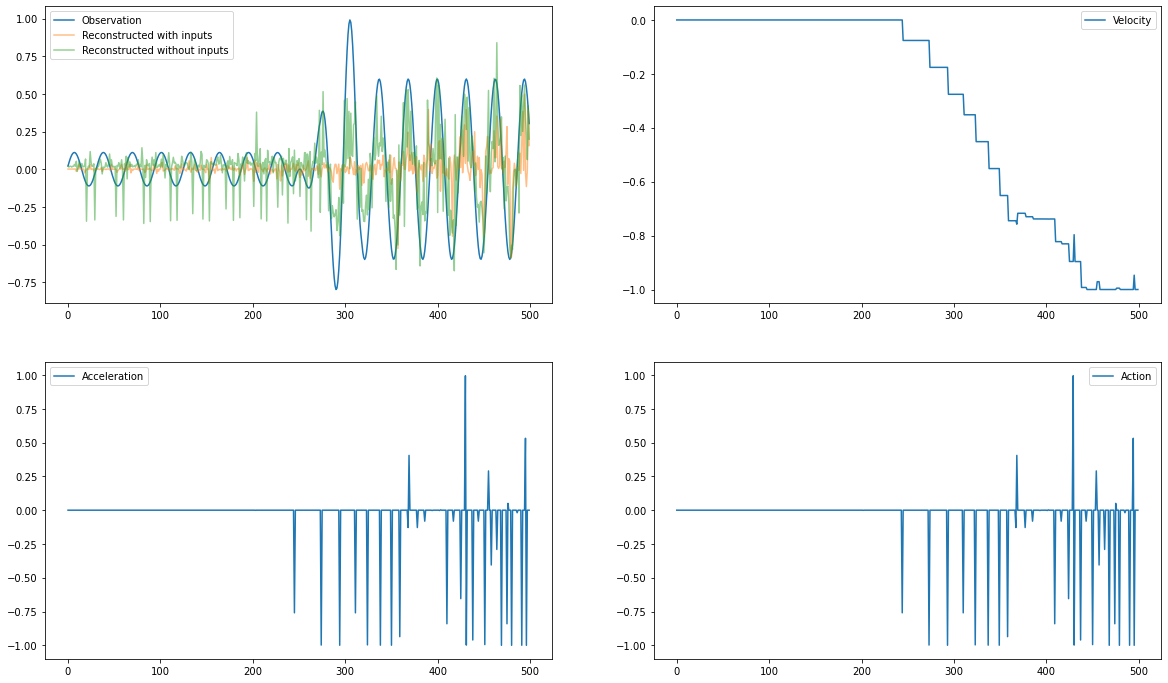

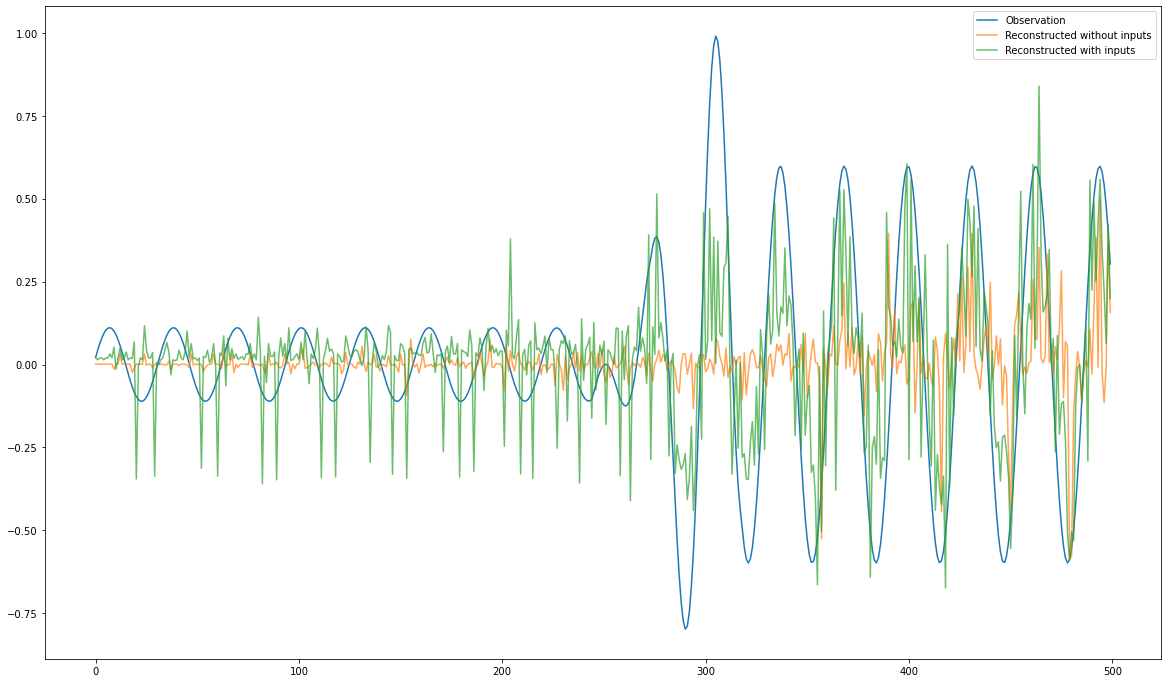

In [ ]:
visualize_linear_predictions(best_num_activations, a_saved, best_ys, best_regressors, quantities_optimized=[0])

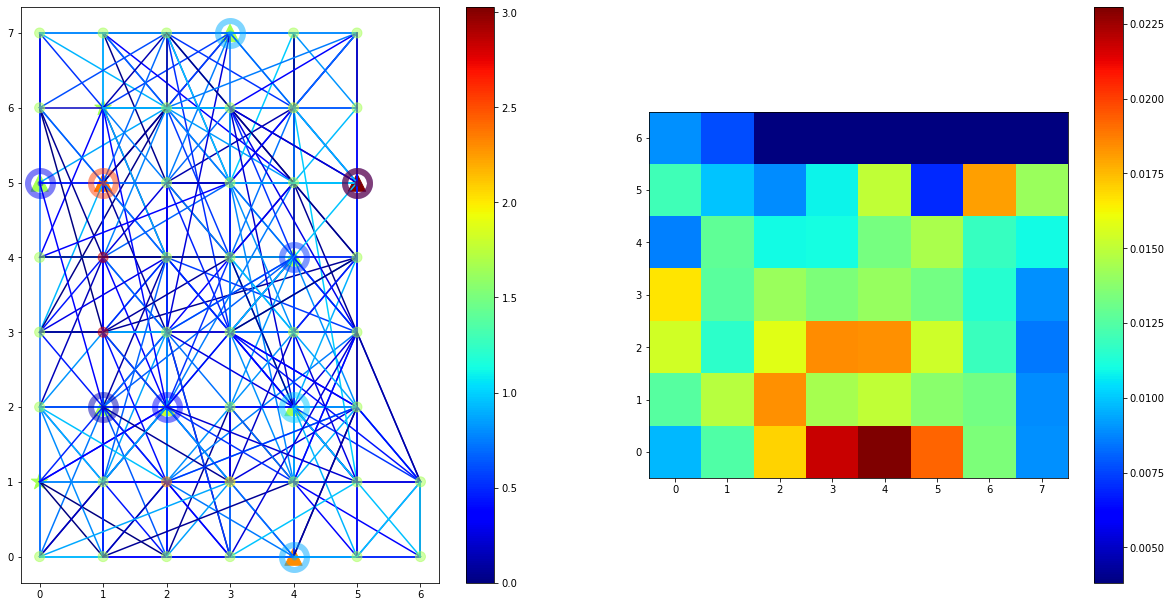

(6738,)


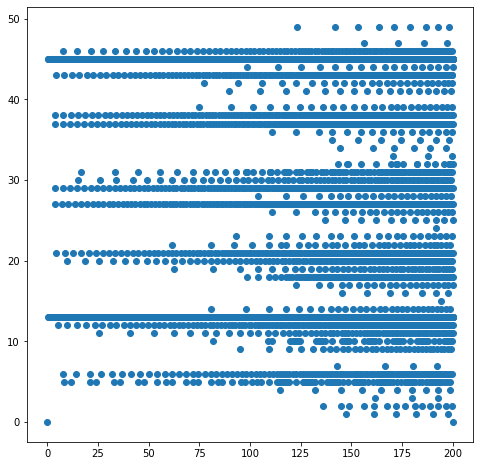

In [ ]:
best_net.visualize_network()
x,y=best_net.raster_plot()
plt.figure(figsize=(8,8))
print(np.array(x).shape)
plt.scatter(x,y)

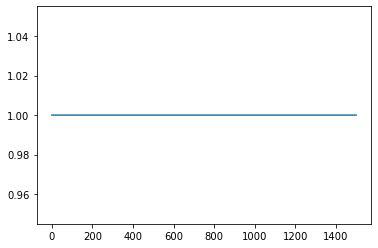

In [ ]:
positions = [frame[2] for frame in best_frames]
acceleration = [frame[-1] for frame in best_frames]

plt.plot(positions)

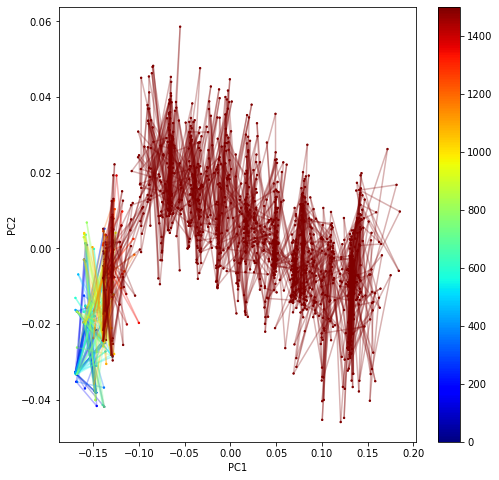

(104719,)


Text(0.5, 1.0, '$\\gamma$ = 1')

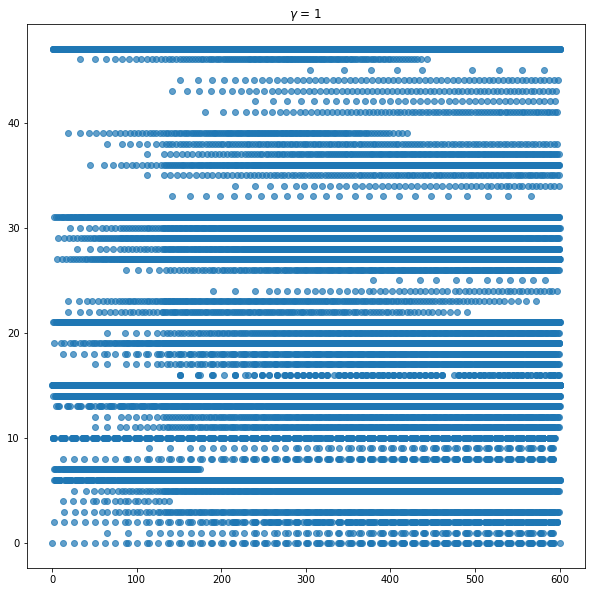

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(best_num_activations)
def visualize_pca(pca_data):
    # plot the first two principal components from pca_data
    fig, ax = plt.subplots(figsize=(8,8))
    # define the colors as the time index of the data (first dimension of pca_data)
    cs = [plt.cm.jet(i) for i in range(len(pca_data))]
    ax.scatter(pca_data[:,0], pca_data[:,1], s=2, c=cs)
    # create a line from data at time t to time t+1
    for i in range(len(pca_data)-1):
        ax.plot([pca_data[i,0], pca_data[i+1,0]], [pca_data[i,1], pca_data[i+1,1]], c=cs[i], alpha=0.3)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    # add colorbar
    fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=len(pca_data))))
    plt.show()
visualize_pca(pca_data = pca.transform(best_num_activations))
x,y=best_net.raster_plot()
plt.figure(figsize=(10,10))
print(np.array(x).shape)
plt.scatter(x,y, alpha=0.7)
plt.title("$\gamma$ = 1")

# Normal running

In [ ]:
env = custom_oneDEnv(interval_size=1, sf=2, ty="Deterministic")
anim = Anim(env.interval)

params_dict = {'physical_dimensions': 2,\
                'p_0': 1, 'lbd': 1.7,\
                'gamma': 10, 'avg_coef': 0.3, \
                'avg_sz_coef': 0.6, 'reset_v': -2,\
                'alpha1': 0.5, 'alpha2': 0.52,\
                'dt': 0.01, 'update_eq': 'LPL', 'leak_current': 0.001}

frames, sum_activations, net, entropies, num_activations, ys = run(iterations=2500, env=env, param_dict=params_dict, s=40, number_of_neurons=50, initial_network=best_net, connection_mat=np.load("data/M_100.npy"))


Iteration: 0	 Action: 3.577601943870421e-29
Iteration: 100	 Action: -4.363817490535992e-39
Iteration: 200	 Action: -2.9198235242085983e-08
Iteration: 300	 Action: -1.10927971160916e-24
Iteration: 400	 Action: 0.9657093176954505
Iteration: 500	 Action: -0.5319336341715335
Iteration: 600	 Action: 4.951859392668766e-31
Iteration: 700	 Action: -0.005291769541622886
Iteration: 800	 Action: 0.9997592323530088
Iteration: 900	 Action: 0.951680927243425
Iteration: 1000	 Action: -0.9995087487266259
Iteration: 1100	 Action: -0.698267537327049
Iteration: 1200	 Action: -0.9970842603482566
Iteration: 1300	 Action: -0.010784427940274151
Iteration: 1400	 Action: 0.7495562373978402
Iteration: 1500	 Action: -0.9321889868463876
Iteration: 1600	 Action: -0.9989979838596394
Iteration: 1700	 Action: -0.9324305884108703
Iteration: 1800	 Action: -1.9982603908395186e-269
Iteration: 1900	 Action: 0.0
Iteration: 2000	 Action: 0.0
Iteration: 2100	 Action: 0.0
Iteration: 2200	 Action: 0.0
Iteration: 2300	 Action: 

In [ ]:
import os
# make the data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')
# find out the number of the last num_activations_{}.npy file
num = 0
while os.path.exists("data/num_activations_{}.npy".format(num)):
    num += 1
np.save(f"data/num_activations_{num}.npy", num_activations)

In [ ]:
# perform pca on num_activations using sklearn 
from sklearn.decomposition import PCA
# load all the num_activations_{}.npy files and concatenate them
#num_activations_all = np.concatenate([np.load("data/num_activations_{}.npy".format(i)) for i in range(num)])
pca = PCA(n_components=2)
pca.fit(num_activations)



PCA(n_components=2)

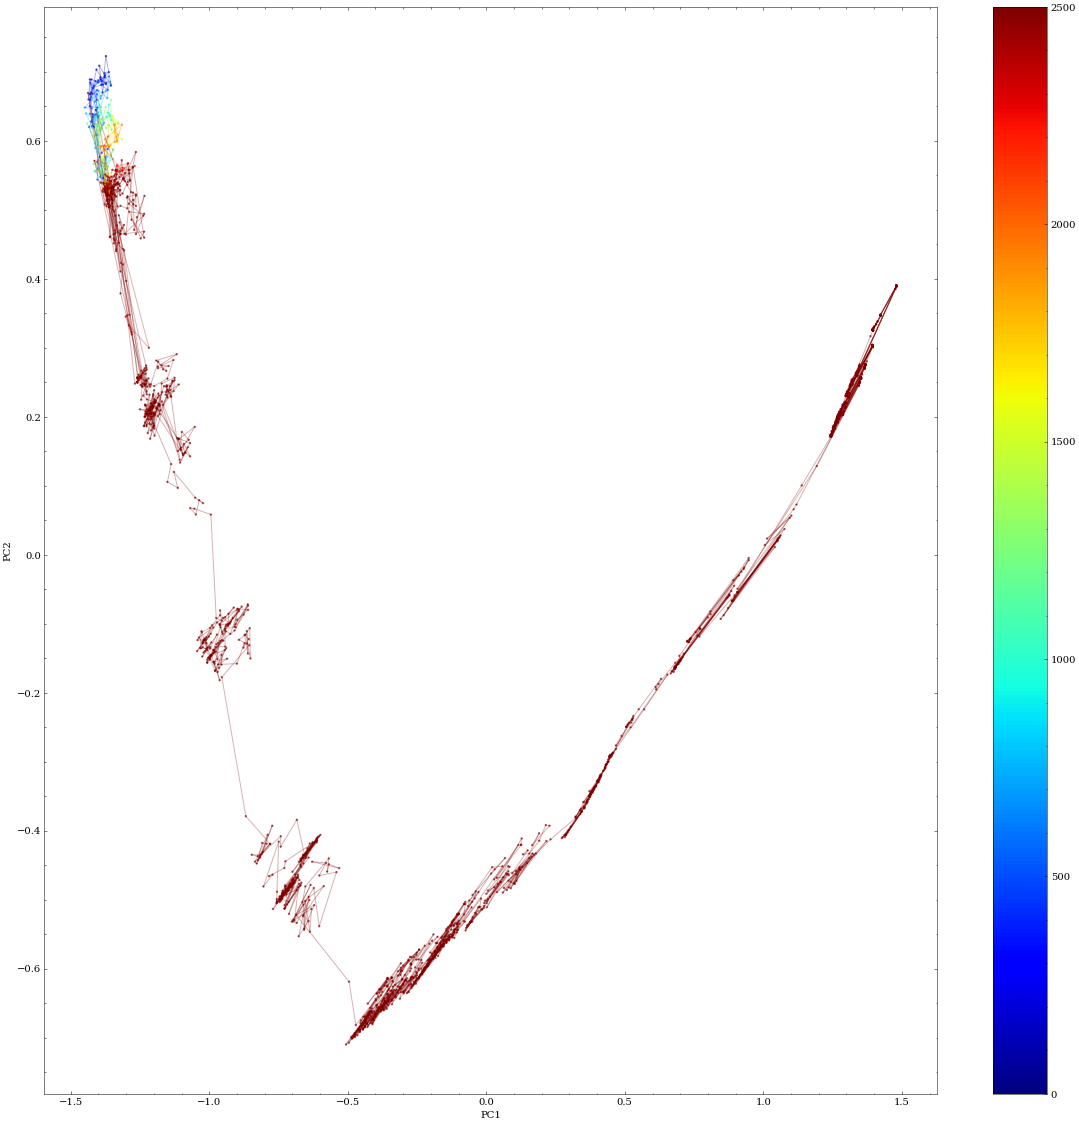

(767787,)


Text(0.5, 1.0, '$\\gamma$ = 1')

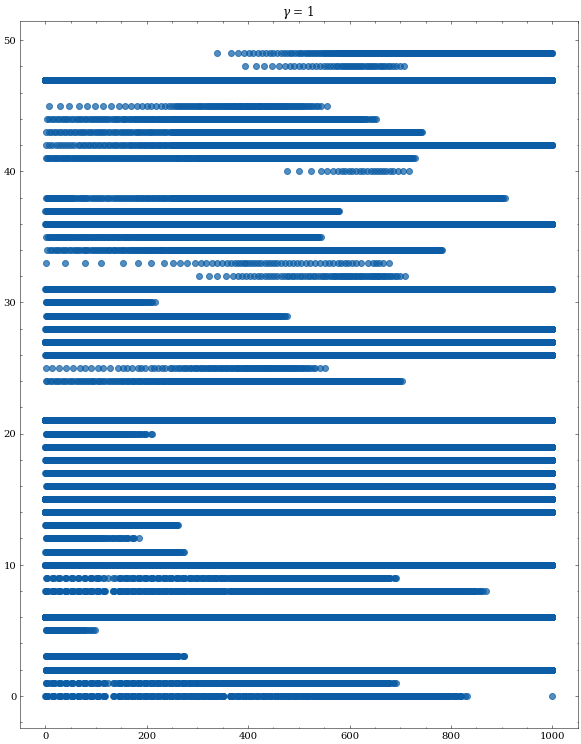

In [ ]:
def visualize_pca(pca_data):
    # plot the first two principal components from pca_data
    fig, ax = plt.subplots(figsize=(20,20))
    # define the colors as the time index of the data (first dimension of pca_data)
    cs = [plt.cm.jet(i) for i in range(len(pca_data))]
    ax.scatter(pca_data[:,0], pca_data[:,1], s=2, c=cs, alpha=0.5)
    # create a line from data at time t to time t+1
    for i in range(len(pca_data)-1):
        ax.plot([pca_data[i,0], pca_data[i+1,0]], [pca_data[i,1], pca_data[i+1,1]], c=cs[i], alpha=0.3)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    # add colorbar
    fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=len(pca_data))))
    plt.show()
visualize_pca(pca_data = pca.transform(num_activations))
x,y=net.raster_plot()
plt.figure(figsize=(10,13))
print(np.array(x).shape)
plt.scatter(x,y, alpha=0.7)
plt.title("$\gamma$ = 1")

In [ ]:
matplotlib.get_configdir()

'C:\\Users\\pizza\\.matplotlib'

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

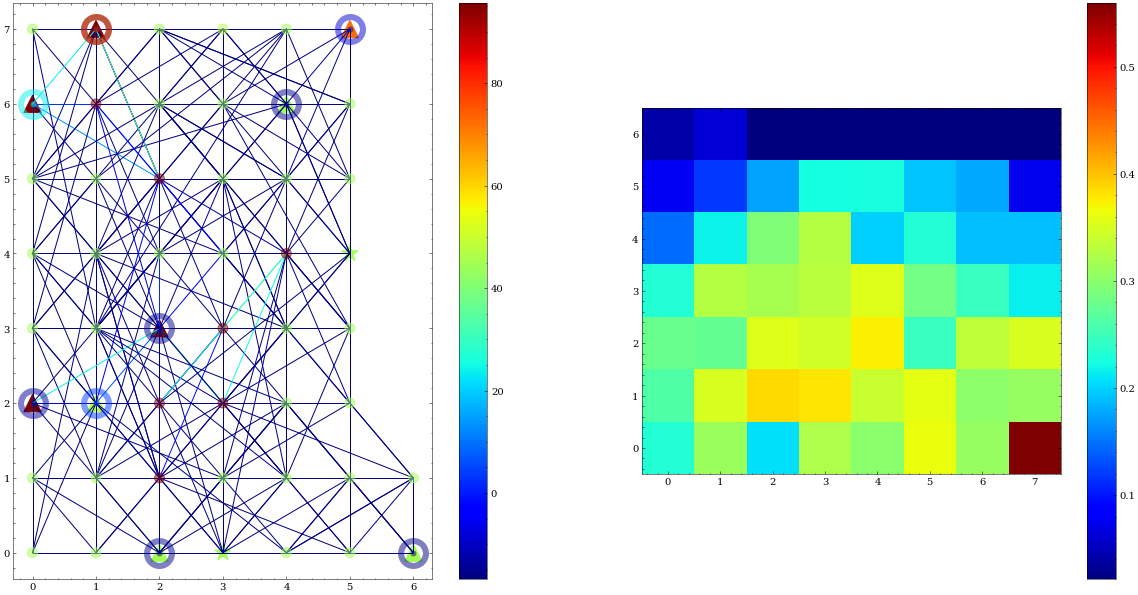

In [ ]:
plt.style.use('science')
net.visualize_network()


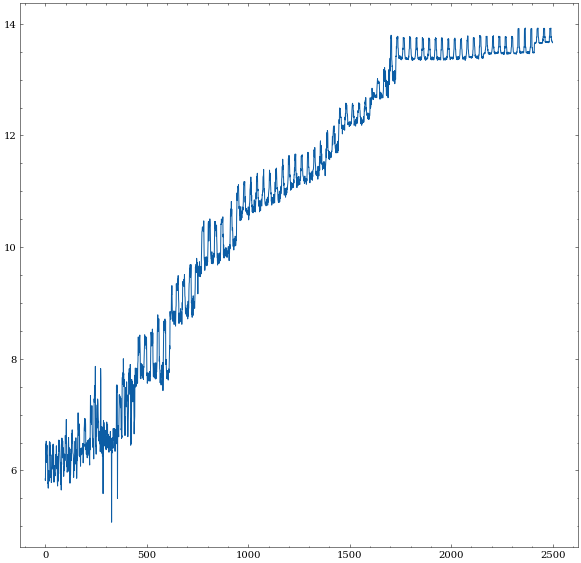

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(entropies)

In [ ]:
net.gamma, net.postsyn_

(10,
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.96340866, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ,

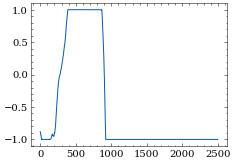

In [ ]:
positions = [frame[2] for frame in frames]
acceleration = [frame[-1] for frame in frames]

plt.plot(positions)

In [ ]:
#create_animation(frames, "yo.gif")